In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from haversine import haversine
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.feature_selection import mutual_info_regression
from math import sqrt


%matplotlib inline

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 100)

In [2]:
train_filepath = './datasets/encoded_X_train.csv'
test_filepath = './datasets/encoded_X_test.csv'
y_train_filepath = './datasets/y_train.csv'


X_train_encoded = pd.read_csv(train_filepath)
X_test_encoded = pd.read_csv(test_filepath)
y_train = pd.read_csv(y_train_filepath).squeeze()

X_train_encoded.head()

,flat_model_2-room,flat_model_Adjoined flat,flat_model_Apartment,flat_model_DBSS,flat_model_Improved,flat_model_Improved-Maisonette,flat_model_Maisonette,flat_model_Model A,flat_model_Model A-Maisonette,flat_model_Model A2,flat_model_Multi Generation,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Premium Apartment Loft,flat_model_Premium Maisonette,flat_model_Simplified,flat_model_Standard,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2,flat_type_1 ROOM,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI-GENERATION,id,tranc_yearmonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,tranc_year,tranc_month,mid_storey,lower,upper,mid,full_flat_type,address,floor_area_sqft,hdb_age,max_floor_lvl,year_completed,residential,...,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,postal,latitude,longitude,planning_area,mall_nearest_distance,mall_within_500m,mall_within_1km,mall_within_2km,hawker_nearest_distance,hawker_within_500m,hawker_within_1km,hawker_within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,mrt_name,bus_interchange,mrt_interchange,mrt_latitude,mrt_longitude,bus_stop_nearest_distance,bus_stop_name,bus_stop_latitude,bus_stop_longitude,pri_sch_nearest_distance,pri_sch_name,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude,average_dist_amenities,count_of_convenience_within_1km,house_coord,distance_to_cityhall,pri_sch_rank,sec_sch_rank,pri_sch_rank_X_distance,sec_sch_rank_X_distance
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,122598,2012-07,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,130.0,Improved,1987,2012,7,4,7,9,8,522908.365193,"153, BISHAN ST 13",1399.320,34,9,1987,Y,...,0,0,0,0,0,0,536247.390101,1.346086,103.855078,625788.359629,866.941448,0.0,1.0,3.0,640.151925,0.0,1.0,7.0,80,77,903.659703,Bishan,1,1,1.350580,103.848305,58.207761,623503.862281,1.345659,103.855381,415.607357,Kuo Chuan Presbyterian Primary School,45,1,1.349783,103.854529,447.894399,Kuo Chuan Presbyterian Secondary School,232,0,1.350110,103.854892,504.406687,4.0,"(1.346085959, 103.8550783)",5894.847771,2,2,831.214714,895.788799
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,170897,2013-07,BUKIT BATOK,EXECUTIVE,289B,BT BATOK ST 25,13 TO 15,144.0,Apartment,1997,2013,7,7,13,15,14,620388.635767,"289B, BT BATOK ST 25",1550.016,24,16,1996,Y,...,0,0,0,0,0,0,564288.621784,1.343867,103.760535,398816.025932,1459.579948,0.0,0.0,4.0,1762.082341,0.0,0.0,1.0,84,95,1334.251197,Bukit Batok,1,0,1.349561,103.749970,214.747860,516462.046776,1.344064,103.758613,498.849039,Keming Primary School,39,0,1.345245,103.756265,180.074558,Yusof Ishak Secondary School,188,0,1.342334,103.760013,952.482609,1.0,"(1.343866875, 103.760535)",11633.683375,1,3,498.849039,540.223673
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,86070,2012-04,BISHAN,4 ROOM,232,BISHAN ST 22,01 TO 05,103.0,Model A,1992,2012,4,2,1,5,3,456235.760726,"232, BISHAN ST 22",1108.692,29,11,1990,Y,...,0,0,0,0,0,0,459432.932676,1.358245,103.845504,625788.359629,950.175199,0.0,1.0,4.0,726.215262,0.0,1.0,9.0,32,86,907.453484,Bishan,1,1,1.350580,103.848305,43.396521,737111.777260,1.358045,103.845169,389.515528,Catholic High School,20,1,1.354789,103.844934,389.515528,Catholic High School,253,1,1.354789,103.844934,516.645199,4.0,"(1.358245182, 103.8455043)",7274.162586,1,1,389.515528,389.515528
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,153632,2017-12,YISHUN,4 ROOM,876,YISHUN ST 81,01 TO 03,83.0,Simplified,1987,2017,12,1,1,3,2,376340.416717,"876, YISHUN ST 81",893.412,34,4,1987,Y,...,0,0,0,

# Running Models and Benchmarking

In [3]:
# Define functions for Linear Regression Workflow first


def create_model(train_X, val_X, train_y, val_y):
    lr = LinearRegression()
    lr.fit(train_X, train_y)
    y_preds = lr.predict(val_X)
    rmse = np.sqrt(mean_squared_error(val_y, y_preds))
    r2_train = lr.score(train_X, train_y)
    r2_val = lr.score(val_X, val_y)
    return rmse, r2_train, r2_val, lr
    

def create_baseline_score(train_X, train_y, cv=5, scoring='neg_root_mean_squared_error'):
    lr = LinearRegression()
    baseline_rmse = -1 * cross_val_score(lr, train_X, train_y, cv=cv, scoring=scoring).mean()
    return baseline_rmse
    

def ordinary_linreg(X_train, y_train, X_test, X_features, 
                    with_poly=False, 
                    include_bias=True, 
                    interaction_only=False, 
                    poly_degree=2,
                    standardscale=True):
    
    
    X_train = X_train[X_features]
    y_train = y_train
    X_test = X_test[X_features]
    
    if with_poly:
        poly = PolynomialFeatures(include_bias=include_bias, interaction_only=interaction_only, degree=poly_degree)
        poly_X_train = poly.fit_transform(X_train)
        poly_X_test = poly.transform(X_test)
        
        if standardscale:
            ss = StandardScaler()
            Z_train = ss.fit_transform(poly_X_train)
            Z_test = ss.transform(poly_X_test) 
            train_X, val_X, train_y, val_y = train_test_split(Z_train, y_train, random_state=0)
            rmse, r2_train, r2_val, fitted_model = create_model(train_X, val_X, train_y, val_y)
            baseline_rmse = create_baseline_score(Z_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
            print(f'RMSE: {rmse}')
            print(f'R2_train: {r2_train}')
            print(f'R2_val: {r2_val}')
            print(f'Baseline cross-val_score: {baseline_rmse}')
            print(f'Number of features: {len(fitted_model.coef_)}')
            return fitted_model, Z_test
        else:
            train_X, val_X, train_y, val_y = train_test_split(poly_X_train, y_train, random_state=0)
            rmse, r2_train, r2_val, fitted_model = create_model(train_X, val_X, train_y, val_y)
            baseline_rmse = create_baseline_score(poly_X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
            print(f'RMSE: {rmse}')
            print(f'R2_train: {r2_train}')
            print(f'R2_val: {r2_val}')
            print(f'Baseline cross-val_score: {baseline_rmse}')
            print(f'Number of features: {len(fitted_model.coef_)}')
            return fitted_model, poly_X_test
    
        
    elif standardscale:
        ss = StandardScaler()
        Z_train = ss.fit_transform(X_train)
        Z_test = ss.transform(X_test) 
        train_X, val_X, train_y, val_y = train_test_split(Z_train, y_train, random_state=0)
        rmse, r2_train, r2_val, fitted_model = create_model(train_X, val_X, train_y, val_y)
        baseline_rmse = create_baseline_score(Z_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
        print(f'RMSE: {rmse}')
        print(f'R2_train: {r2_train}')
        print(f'R2_val: {r2_val}')
        print(f'Baseline cross-val_score: {baseline_rmse}')
        print(f'Number of features: {len(fitted_model.coef_)}')
        return fitted_model, Z_test

    else:  # no standardscaling
        train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, random_state=0)
        rmse, r2_train, r2_val, fitted_model = create_model(train_X, val_X, train_y, val_y)
        baseline_rmse = create_baseline_score(X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
        print(f'RMSE: {rmse}')
        print(f'R2_train: {r2_train}')
        print(f'R2_val: {r2_val}')
        print(f'Baseline cross-val_score: {baseline_rmse}')
        print(f'Number of features: {len(fitted_model.coef_)}')
        return fitted_model, X_test
    
    

def ridgeCV(X_train, y_train, X_test, X_features, 
                    with_poly=False, 
                    include_bias=True, 
                    interaction_only=False, 
                    poly_degree=2,
                    ):
    
    
    X_train = X_train[X_features]
    y_train = y_train
    X_test = X_test[X_features]
    
    if with_poly:
        poly = PolynomialFeatures(include_bias=include_bias, interaction_only=interaction_only, degree=poly_degree)
        poly_X_train = poly.fit_transform(X_train)
        poly_X_test = poly.transform(X_test)
        ss = StandardScaler()
        Z_train = ss.fit_transform(poly_X_train)
        Z_test = ss.transform(poly_X_test) 
        
        r_alphas = np.logspace(0,5,100)
        train_X, val_X, train_y, val_y = train_test_split(Z_train, y_train, random_state=0)
        ridge_cv = RidgeCV(alphas=r_alphas, scoring='neg_mean_squared_error', cv=5)
        ridge_cv.fit(train_X, train_y)
        y_preds = ridge_cv.predict(val_X)
        rmse = sqrt(mean_squared_error(val_y, y_preds))
        print(f'Number of features: {len(ridge_cv.coef_)}')
        print(f'RMSE: {rmse}')
        return ridge_cv, Z_test
        
    else:
        ss = StandardScaler()
        Z_train = ss.fit_transform(X_train)
        Z_test = ss.transform(X_test) 
        
        r_alphas = np.logspace(0,5,100)
        train_X, val_X, train_y, val_y = train_test_split(Z_train, y_train, random_state=0)
        ridge_cv = RidgeCV(alphas=r_alphas, scoring='neg_mean_squared_error', cv=5)
        ridge_cv.fit(Z_train, y_train)
        y_preds = ridge_cv.predict(val_X)
        rmse = sqrt(mean_squared_error(val_y, y_preds))
        print(f'Number of features: {len(ridge_cv.coef_)}')
        print(f'RMSE: {rmse}')
        return ridge_cv, Z_test
    
    

    
def lassoCV(X_train, y_train, X_test, X_features, 
                    with_poly=False, 
                    include_bias=True, 
                    interaction_only=False, 
                    poly_degree=2,
                    ):
    
    
    X_train = X_train[X_features]
    y_train = y_train
    X_test = X_test[X_features]
    
    if with_poly:
        poly = PolynomialFeatures(include_bias=include_bias, interaction_only=interaction_only, degree=poly_degree)
        poly_X_train = poly.fit_transform(X_train)
        poly_X_test = poly.transform(X_test)
        ss = StandardScaler()
        Z_train = ss.fit_transform(poly_X_train)
        Z_test = ss.transform(poly_X_test) 
        
        l_alphas = np.logspace(-3,0,100)
        train_X, val_X, train_y, val_y = train_test_split(Z_train, y_train, random_state=0)
        lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=50000)
        lasso_cv.fit(train_X, train_y)
        y_preds = lasso_cv.predict(val_X)
        rmse = sqrt(mean_squared_error(val_y, y_preds))
        print(f'Number of features: {len(lasso_cv.coef_)}')
        print(f'RMSE: {rmse}')
        return lasso_cv, Z_test
        
    else:
        ss = StandardScaler()
        Z_train = ss.fit_transform(X_train)
        Z_test = ss.transform(X_test) 
        
        l_alphas = np.logspace(-3,0,100)
        train_X, val_X, train_y, val_y = train_test_split(Z_train, y_train, random_state=0)
        lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=50000)
        lasso_cv.fit(train_X, train_y)
        y_preds = lasso_cv.predict(val_X)
        rmse = sqrt(mean_squared_error(val_y, y_preds))
        print(f'Number of features: {len(lasso_cv.coef_)}')
        print(f'RMSE: {rmse}')
        return lasso_cv, Z_test

In [4]:
# Select X features to train on here

X_features = ['floor_area_sqm',
            'postal',  
              'bus_stop_name',
              'full_flat_type',
              'planning_area',
              'hdb_age',
            'total_dwelling_units', 
#             'flat_type_1 ROOM', 'flat_type_2 ROOM', 'flat_type_3 ROOM',
#        'flat_type_4 ROOM', 'flat_type_5 ROOM', 'flat_type_EXECUTIVE',
#        'flat_type_MULTI-GENERATION',
              'mid_storey',
              'max_floor_lvl',
              'mrt_nearest_distance',
              'hawker_nearest_distance',
              'bus_stop_nearest_distance',
              'count_of_convenience_within_1km',
            'average_dist_amenities',
            'pri_sch_nearest_distance',
            'pri_sch_rank',
              'sec_sch_rank',
#               'pri_sch_rank_X_distance',  
#               'sec_sch_rank_X_distance',
              'distance_to_cityhall',
#               'mall_within_500m',

             ]



In [15]:
# Fitting LinReg model and raising degree of polynomial to 4, with standard-scaling

fitted_model, transformed_X_test = ordinary_linreg(X_train_encoded, y_train, X_test_encoded, X_features, 
                                                   with_poly=True, 
                                                   poly_degree=4, 
                                                   standardscale=True)

RMSE: 37671.271251264996
R2_train: 0.9399932566642901
R2_val: 0.9306000053672123
Baseline cross-val_score: 37758.3994614473
Number of features: 4845


In [5]:
# Fitting a simple LinReg without raising polynomials and standard-scaling

fitted_model_2, transformed_X_test = ordinary_linreg(X_train_encoded, y_train, X_test_encoded, X_features, 
                                 with_poly=False, 
                                 poly_degree=4, 
                                 standardscale=True)

RMSE: 54859.498539295506
R2_train: 0.8543176133325272
R2_val: 0.8528221170543249
Baseline cross-val_score: 54629.0774099249
Number of features: 18


In [19]:
# Run optimal feature set with RidgeCV

ridge_model, transformed_X_test = ridgeCV(X_train_encoded, y_train, X_test_encoded, X_features, 
                        with_poly=False, 
                        poly_degree=4)

Number of features: 18
RMSE: 54834.83141608184


In [20]:
# Run optimal feature set with LassoCV

lasso_model, transformed_X_test = lassoCV(X_train_encoded, y_train, X_test_encoded, X_features, 
                        with_poly=False, 
                        poly_degree=4)

Number of features: 18
RMSE: 54859.12329108551


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.072e+11, tolerance: 1.717e+11
  model = cd_fast.enet_coordinate_descent(


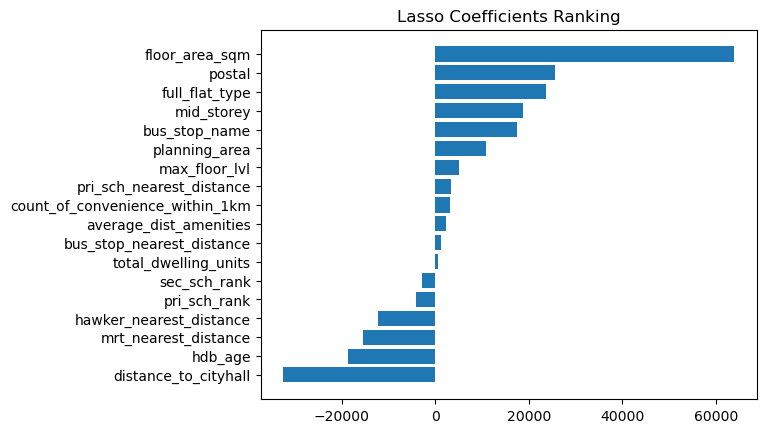

<Figure size 10000x20000 with 0 Axes>

In [44]:
# Plot optimal Lasso model coefficients

lasso_coefficients = pd.Series(lasso_model.coef_, index=X_features).sort_values(ascending=True)

width = np.arange(len(lasso_coefficients))
ticks = list(lasso_coefficients.index)
plt.barh(width, lasso_coefficients)
plt.yticks(width, ticks)
plt.title("Lasso Coefficients Ranking")

plt.figure(dpi=500,figsize=(20,40));


# total_dwelling_units, bus_stop_nearest_distance, average_dist_amenities are closest to 0 per Lasso rankings

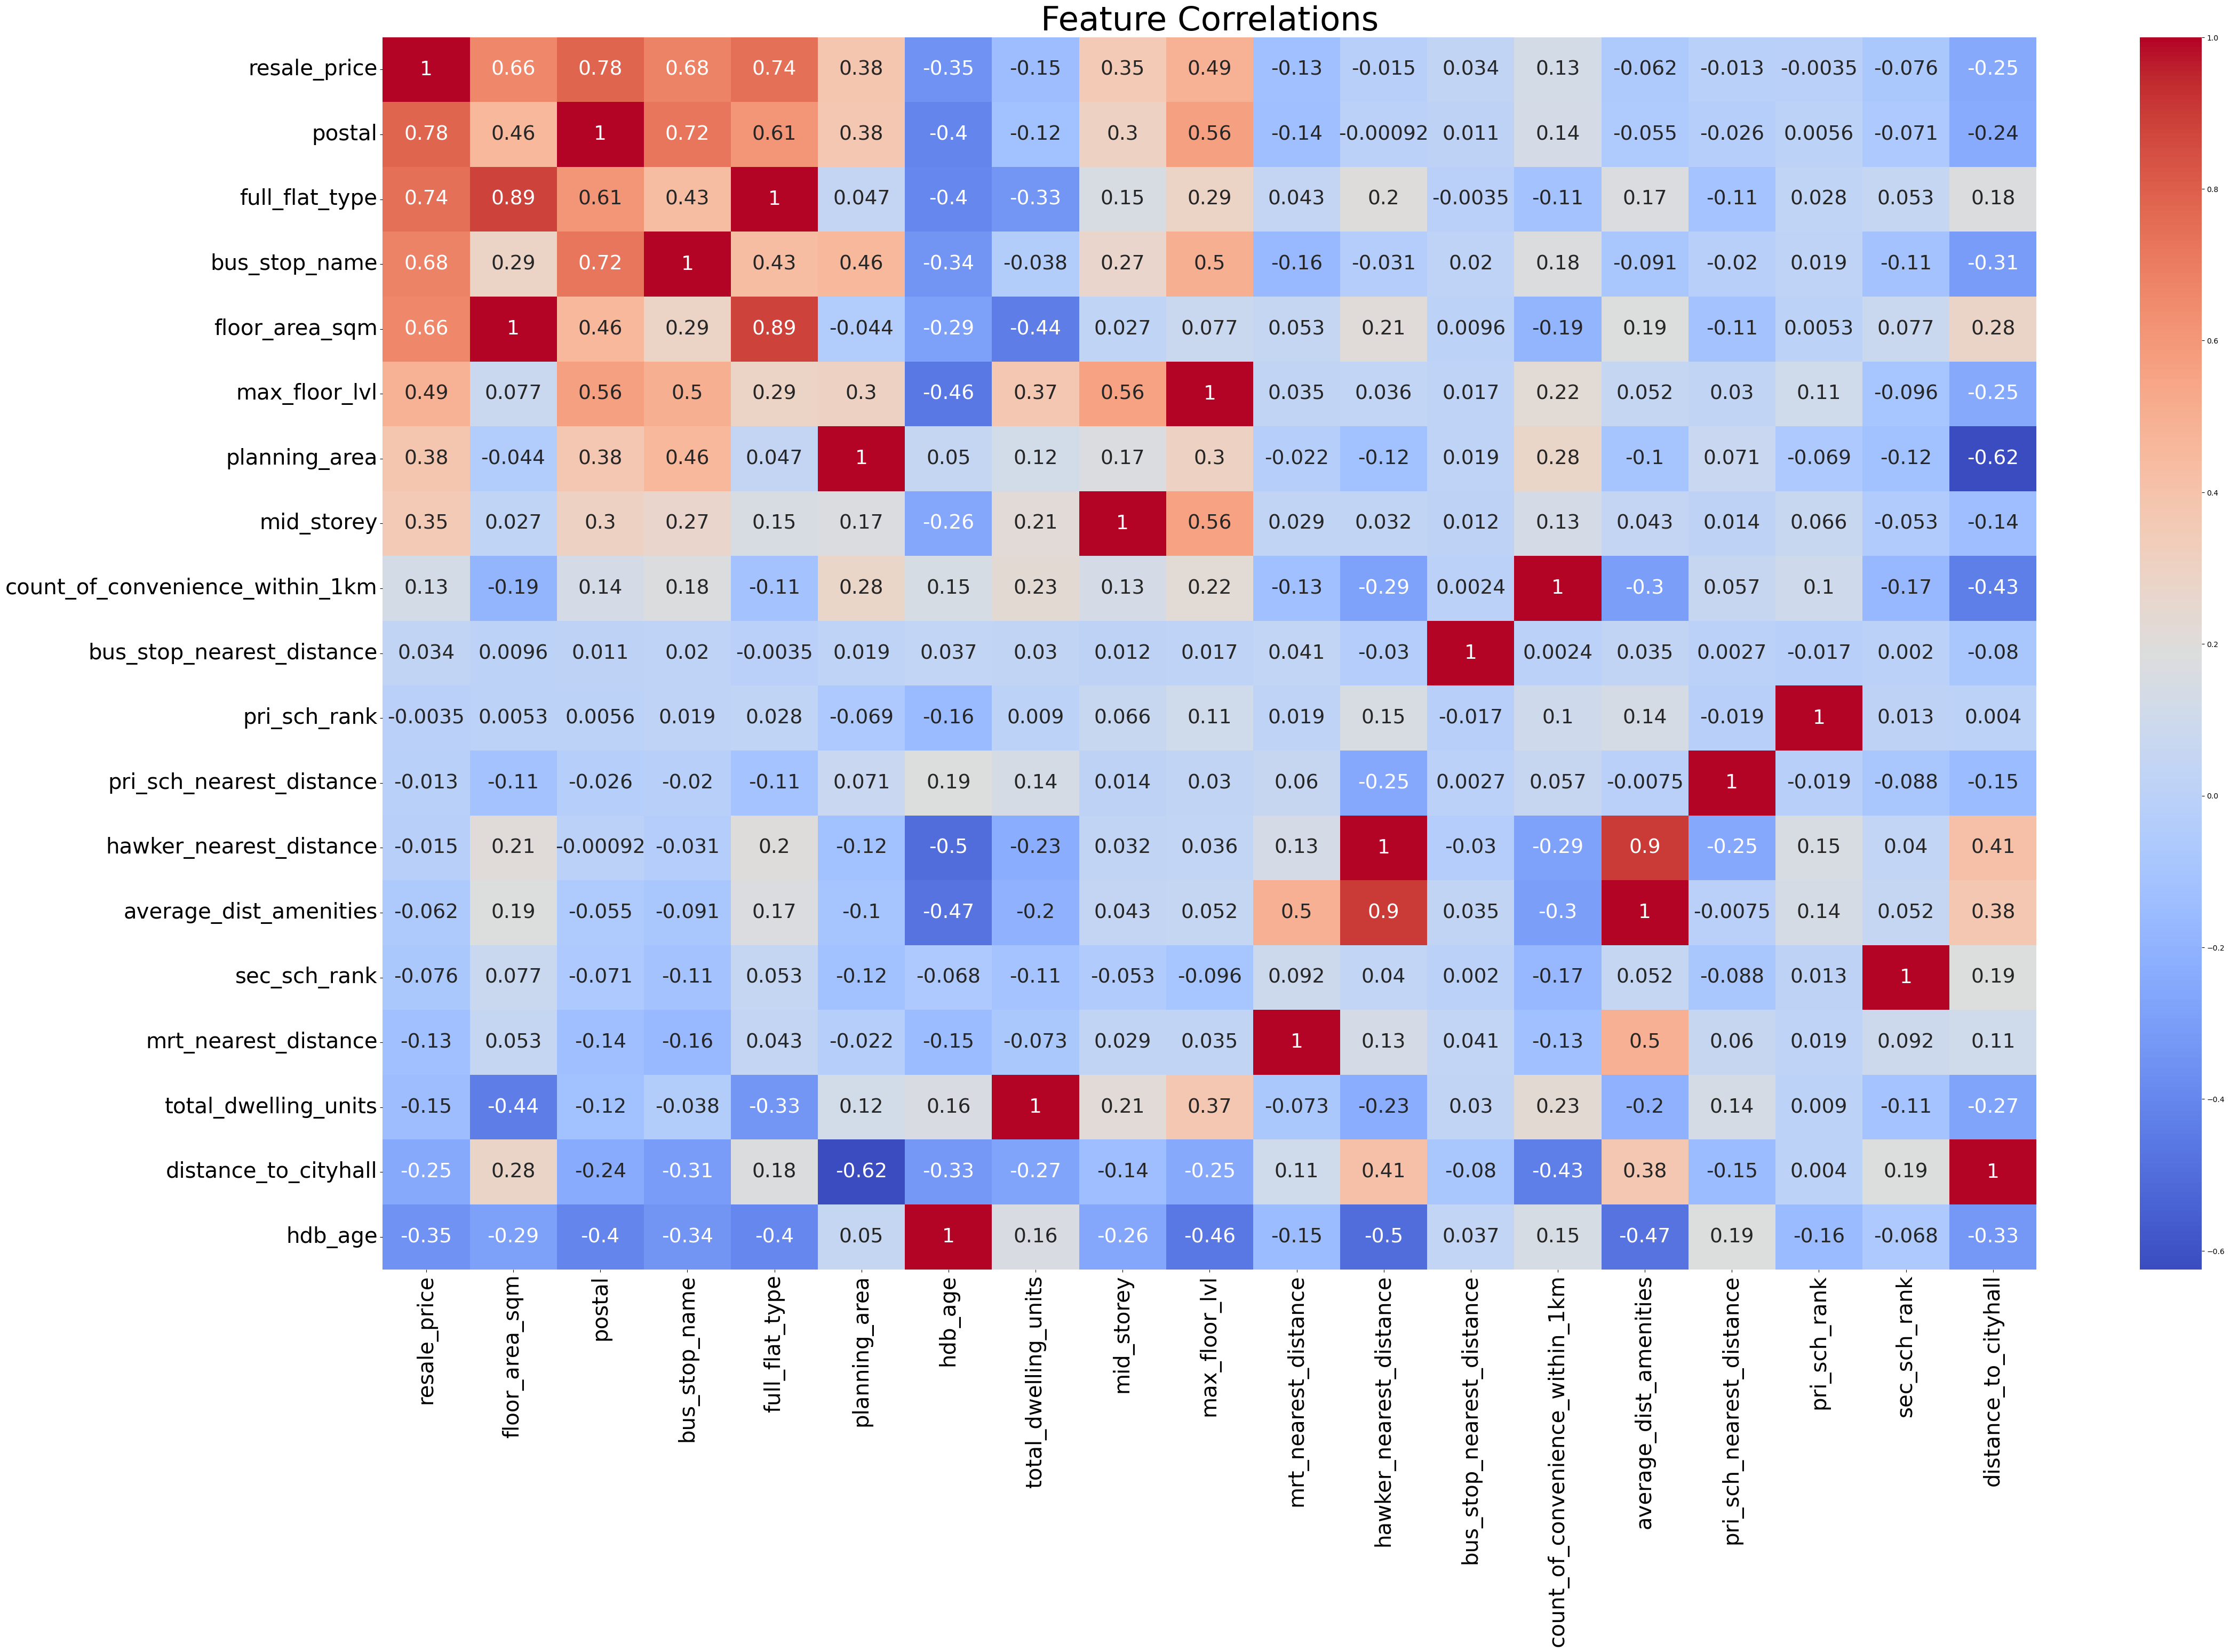

In [29]:
# Correlation heatmap of selected features

X_train_correlations = X_train_encoded[X_features].copy().corr()
X_train_encoded_with_resale_prices['resale_price'] = y_train
X_train_correlations = X_train_encoded_with_resale_prices.corr()
X_train_correlations.insert(0, 'resale_price', X_train_correlations.pop('resale_price'))   # shift resale_price col to leftmost
X_train_correlations = X_train_correlations.sort_values('resale_price', ascending=False)  # sort corr in the first col

plt.figure(figsize=(50,30))
sns.heatmap(X_train_correlations, cmap='coolwarm', annot=True, annot_kws={"fontsize": 27})
plt.tick_params(axis='both', labelsize=29)
plt.title("Feature Correlations", fontsize=45);

# Part 2: Model Results Evaluation

|Model|Std.Scaled|Num_of_Features|training_RMSE|baseline_RMSE|RidgeCV_RMSE|LassoCV_RMSE|Polynomial_4_train_RMSE|Polynomial_4_baseline_RMSE|Num_of_Poly_Features|Recommended|
|:---|---|:---:|---|---:|---|---|---|---|---|---|
|1|Yes|14|\$ 55,260|\$ 54,975|\$55,240|\$55,261|\$ 38,779|\$ 38,216|3,060|
|2|Yes|15|\$ 54,877|\$ 54,641|\$ 54,855|\$ 54,877|\$ 37,693|\$ 37,654|3,876|
|3|Yes|16|\$ 54,855|\$ 54,624|\$ 54,833|\$ 54,855|\$ 37,671|\$ 37,758|4,845|Yes|
|4|Yes|18|\$ 54,860|\$ 54,630|\$ 54,834 |\$ 54,859|\$ 37,760|\$ 37,766|7,315|
|5|Yes|21|\$ 54,849|\$ 54,609|\$ 54,821|\$ 54,849|n/a|n/a|n/a|
|6|Yes|28|\$ 54,571|\$ 54,314|\$ 54,550|\$54,571|n/a|n/a|n/a|

Beyond a certain number of features and degrees of polynomial, model performance cease to improve meaningfully

For the basic LinReg models, standard-scaling of features hardly affected the performance scores

If there is no overfitting in the basic model, then RidgeCV and LassoCV produces same results. 



### Optimal set of 18 features are: 
    'floor_area_sqm',
    'postal',  
    'bus_stop_name',
    'full_flat_type',
    'planning_area',
    'hdb_age',
    'total_dwelling_units', 
    'mid_storey',
    'max_floor_lvl',
    'mrt_nearest_distance',
    'hawker_nearest_distance',
    'bus_stop_nearest_distance',
    'count_of_convenience_within_1km',
    'average_dist_amenities',
    'pri_sch_nearest_distance',
    'pri_sch_rank',
    'sec_sch_rank',
    'distance_to_cityhall'


# Part 3: Trying out other feature selection approach

In [6]:
# Recreate the optimum polynomial X_train set here to explore further optimization and feature selection

poly = PolynomialFeatures(include_bias=True, interaction_only=False, degree=4)
poly_X_train = poly.fit_transform(X_train_encoded[X_features])
poly_X_test = poly.transform(X_test_encoded[X_features])

X_poly_df = pd.DataFrame(poly_X_train, columns=poly.get_feature_names_out())
X_poly_df_test = pd.DataFrame(poly_X_test, columns=poly.get_feature_names_out())

In [126]:
# Running LinReg for each feature of X_poly_df individually to get feature's r-squared score

rmse_series = []
count=0

for col in X_poly_df.columns:
    lr = LinearRegression()
    lr.fit(X_poly_df[[col]], y_train)
    r2_score = lr.score(X_poly_df[[col]], y_train)
    rmse_series.append(r2_score)
    count+=1
    print(f'Count {count} saved')

rmse_df = pd.DataFrame(rmse_series, index=X_poly_df.columns)

Count 1 saved
Count 2 saved
Count 3 saved
Count 4 saved
Count 5 saved
Count 6 saved
Count 7 saved
Count 8 saved
Count 9 saved
Count 10 saved
Count 11 saved
Count 12 saved
Count 13 saved
Count 14 saved
Count 15 saved
Count 16 saved
Count 17 saved
Count 18 saved
Count 19 saved
Count 20 saved
Count 21 saved
Count 22 saved
Count 23 saved
Count 24 saved
Count 25 saved
Count 26 saved
Count 27 saved
Count 28 saved
Count 29 saved
Count 30 saved
Count 31 saved
Count 32 saved
Count 33 saved
Count 34 saved
Count 35 saved
Count 36 saved
Count 37 saved
Count 38 saved
Count 39 saved
Count 40 saved
Count 41 saved
Count 42 saved
Count 43 saved
Count 44 saved
Count 45 saved
Count 46 saved
Count 47 saved
Count 48 saved
Count 49 saved
Count 50 saved
Count 51 saved
Count 52 saved
Count 53 saved
Count 54 saved
Count 55 saved
Count 56 saved
Count 57 saved
Count 58 saved
Count 59 saved
Count 60 saved
Count 61 saved
Count 62 saved
Count 63 saved
Count 64 saved
Count 65 saved
Count 66 saved
Count 67 saved
Coun

Count 521 saved
Count 522 saved
Count 523 saved
Count 524 saved
Count 525 saved
Count 526 saved
Count 527 saved
Count 528 saved
Count 529 saved
Count 530 saved
Count 531 saved
Count 532 saved
Count 533 saved
Count 534 saved
Count 535 saved
Count 536 saved
Count 537 saved
Count 538 saved
Count 539 saved
Count 540 saved
Count 541 saved
Count 542 saved
Count 543 saved
Count 544 saved
Count 545 saved
Count 546 saved
Count 547 saved
Count 548 saved
Count 549 saved
Count 550 saved
Count 551 saved
Count 552 saved
Count 553 saved
Count 554 saved
Count 555 saved
Count 556 saved
Count 557 saved
Count 558 saved
Count 559 saved
Count 560 saved
Count 561 saved
Count 562 saved
Count 563 saved
Count 564 saved
Count 565 saved
Count 566 saved
Count 567 saved
Count 568 saved
Count 569 saved
Count 570 saved
Count 571 saved
Count 572 saved
Count 573 saved
Count 574 saved
Count 575 saved
Count 576 saved
Count 577 saved
Count 578 saved
Count 579 saved
Count 580 saved
Count 581 saved
Count 582 saved
Count 58

Count 1043 saved
Count 1044 saved
Count 1045 saved
Count 1046 saved
Count 1047 saved
Count 1048 saved
Count 1049 saved
Count 1050 saved
Count 1051 saved
Count 1052 saved
Count 1053 saved
Count 1054 saved
Count 1055 saved
Count 1056 saved
Count 1057 saved
Count 1058 saved
Count 1059 saved
Count 1060 saved
Count 1061 saved
Count 1062 saved
Count 1063 saved
Count 1064 saved
Count 1065 saved
Count 1066 saved
Count 1067 saved
Count 1068 saved
Count 1069 saved
Count 1070 saved
Count 1071 saved
Count 1072 saved
Count 1073 saved
Count 1074 saved
Count 1075 saved
Count 1076 saved
Count 1077 saved
Count 1078 saved
Count 1079 saved
Count 1080 saved
Count 1081 saved
Count 1082 saved
Count 1083 saved
Count 1084 saved
Count 1085 saved
Count 1086 saved
Count 1087 saved
Count 1088 saved
Count 1089 saved
Count 1090 saved
Count 1091 saved
Count 1092 saved
Count 1093 saved
Count 1094 saved
Count 1095 saved
Count 1096 saved
Count 1097 saved
Count 1098 saved
Count 1099 saved
Count 1100 saved
Count 1101 sav

Count 1534 saved
Count 1535 saved
Count 1536 saved
Count 1537 saved
Count 1538 saved
Count 1539 saved
Count 1540 saved
Count 1541 saved
Count 1542 saved
Count 1543 saved
Count 1544 saved
Count 1545 saved
Count 1546 saved
Count 1547 saved
Count 1548 saved
Count 1549 saved
Count 1550 saved
Count 1551 saved
Count 1552 saved
Count 1553 saved
Count 1554 saved
Count 1555 saved
Count 1556 saved
Count 1557 saved
Count 1558 saved
Count 1559 saved
Count 1560 saved
Count 1561 saved
Count 1562 saved
Count 1563 saved
Count 1564 saved
Count 1565 saved
Count 1566 saved
Count 1567 saved
Count 1568 saved
Count 1569 saved
Count 1570 saved
Count 1571 saved
Count 1572 saved
Count 1573 saved
Count 1574 saved
Count 1575 saved
Count 1576 saved
Count 1577 saved
Count 1578 saved
Count 1579 saved
Count 1580 saved
Count 1581 saved
Count 1582 saved
Count 1583 saved
Count 1584 saved
Count 1585 saved
Count 1586 saved
Count 1587 saved
Count 1588 saved
Count 1589 saved
Count 1590 saved
Count 1591 saved
Count 1592 sav

Count 2017 saved
Count 2018 saved
Count 2019 saved
Count 2020 saved
Count 2021 saved
Count 2022 saved
Count 2023 saved
Count 2024 saved
Count 2025 saved
Count 2026 saved
Count 2027 saved
Count 2028 saved
Count 2029 saved
Count 2030 saved
Count 2031 saved
Count 2032 saved
Count 2033 saved
Count 2034 saved
Count 2035 saved
Count 2036 saved
Count 2037 saved
Count 2038 saved
Count 2039 saved
Count 2040 saved
Count 2041 saved
Count 2042 saved
Count 2043 saved
Count 2044 saved
Count 2045 saved
Count 2046 saved
Count 2047 saved
Count 2048 saved
Count 2049 saved
Count 2050 saved
Count 2051 saved
Count 2052 saved
Count 2053 saved
Count 2054 saved
Count 2055 saved
Count 2056 saved
Count 2057 saved
Count 2058 saved
Count 2059 saved
Count 2060 saved
Count 2061 saved
Count 2062 saved
Count 2063 saved
Count 2064 saved
Count 2065 saved
Count 2066 saved
Count 2067 saved
Count 2068 saved
Count 2069 saved
Count 2070 saved
Count 2071 saved
Count 2072 saved
Count 2073 saved
Count 2074 saved
Count 2075 sav

Count 2504 saved
Count 2505 saved
Count 2506 saved
Count 2507 saved
Count 2508 saved
Count 2509 saved
Count 2510 saved
Count 2511 saved
Count 2512 saved
Count 2513 saved
Count 2514 saved
Count 2515 saved
Count 2516 saved
Count 2517 saved
Count 2518 saved
Count 2519 saved
Count 2520 saved
Count 2521 saved
Count 2522 saved
Count 2523 saved
Count 2524 saved
Count 2525 saved
Count 2526 saved
Count 2527 saved
Count 2528 saved
Count 2529 saved
Count 2530 saved
Count 2531 saved
Count 2532 saved
Count 2533 saved
Count 2534 saved
Count 2535 saved
Count 2536 saved
Count 2537 saved
Count 2538 saved
Count 2539 saved
Count 2540 saved
Count 2541 saved
Count 2542 saved
Count 2543 saved
Count 2544 saved
Count 2545 saved
Count 2546 saved
Count 2547 saved
Count 2548 saved
Count 2549 saved
Count 2550 saved
Count 2551 saved
Count 2552 saved
Count 2553 saved
Count 2554 saved
Count 2555 saved
Count 2556 saved
Count 2557 saved
Count 2558 saved
Count 2559 saved
Count 2560 saved
Count 2561 saved
Count 2562 sav

Count 2993 saved
Count 2994 saved
Count 2995 saved
Count 2996 saved
Count 2997 saved
Count 2998 saved
Count 2999 saved
Count 3000 saved
Count 3001 saved
Count 3002 saved
Count 3003 saved
Count 3004 saved
Count 3005 saved
Count 3006 saved
Count 3007 saved
Count 3008 saved
Count 3009 saved
Count 3010 saved
Count 3011 saved
Count 3012 saved
Count 3013 saved
Count 3014 saved
Count 3015 saved
Count 3016 saved
Count 3017 saved
Count 3018 saved
Count 3019 saved
Count 3020 saved
Count 3021 saved
Count 3022 saved
Count 3023 saved
Count 3024 saved
Count 3025 saved
Count 3026 saved
Count 3027 saved
Count 3028 saved
Count 3029 saved
Count 3030 saved
Count 3031 saved
Count 3032 saved
Count 3033 saved
Count 3034 saved
Count 3035 saved
Count 3036 saved
Count 3037 saved
Count 3038 saved
Count 3039 saved
Count 3040 saved
Count 3041 saved
Count 3042 saved
Count 3043 saved
Count 3044 saved
Count 3045 saved
Count 3046 saved
Count 3047 saved
Count 3048 saved
Count 3049 saved
Count 3050 saved
Count 3051 sav

Count 3481 saved
Count 3482 saved
Count 3483 saved
Count 3484 saved
Count 3485 saved
Count 3486 saved
Count 3487 saved
Count 3488 saved
Count 3489 saved
Count 3490 saved
Count 3491 saved
Count 3492 saved
Count 3493 saved
Count 3494 saved
Count 3495 saved
Count 3496 saved
Count 3497 saved
Count 3498 saved
Count 3499 saved
Count 3500 saved
Count 3501 saved
Count 3502 saved
Count 3503 saved
Count 3504 saved
Count 3505 saved
Count 3506 saved
Count 3507 saved
Count 3508 saved
Count 3509 saved
Count 3510 saved
Count 3511 saved
Count 3512 saved
Count 3513 saved
Count 3514 saved
Count 3515 saved
Count 3516 saved
Count 3517 saved
Count 3518 saved
Count 3519 saved
Count 3520 saved
Count 3521 saved
Count 3522 saved
Count 3523 saved
Count 3524 saved
Count 3525 saved
Count 3526 saved
Count 3527 saved
Count 3528 saved
Count 3529 saved
Count 3530 saved
Count 3531 saved
Count 3532 saved
Count 3533 saved
Count 3534 saved
Count 3535 saved
Count 3536 saved
Count 3537 saved
Count 3538 saved
Count 3539 sav

Count 3963 saved
Count 3964 saved
Count 3965 saved
Count 3966 saved
Count 3967 saved
Count 3968 saved
Count 3969 saved
Count 3970 saved
Count 3971 saved
Count 3972 saved
Count 3973 saved
Count 3974 saved
Count 3975 saved
Count 3976 saved
Count 3977 saved
Count 3978 saved
Count 3979 saved
Count 3980 saved
Count 3981 saved
Count 3982 saved
Count 3983 saved
Count 3984 saved
Count 3985 saved
Count 3986 saved
Count 3987 saved
Count 3988 saved
Count 3989 saved
Count 3990 saved
Count 3991 saved
Count 3992 saved
Count 3993 saved
Count 3994 saved
Count 3995 saved
Count 3996 saved
Count 3997 saved
Count 3998 saved
Count 3999 saved
Count 4000 saved
Count 4001 saved
Count 4002 saved
Count 4003 saved
Count 4004 saved
Count 4005 saved
Count 4006 saved
Count 4007 saved
Count 4008 saved
Count 4009 saved
Count 4010 saved
Count 4011 saved
Count 4012 saved
Count 4013 saved
Count 4014 saved
Count 4015 saved
Count 4016 saved
Count 4017 saved
Count 4018 saved
Count 4019 saved
Count 4020 saved
Count 4021 sav

Count 4454 saved
Count 4455 saved
Count 4456 saved
Count 4457 saved
Count 4458 saved
Count 4459 saved
Count 4460 saved
Count 4461 saved
Count 4462 saved
Count 4463 saved
Count 4464 saved
Count 4465 saved
Count 4466 saved
Count 4467 saved
Count 4468 saved
Count 4469 saved
Count 4470 saved
Count 4471 saved
Count 4472 saved
Count 4473 saved
Count 4474 saved
Count 4475 saved
Count 4476 saved
Count 4477 saved
Count 4478 saved
Count 4479 saved
Count 4480 saved
Count 4481 saved
Count 4482 saved
Count 4483 saved
Count 4484 saved
Count 4485 saved
Count 4486 saved
Count 4487 saved
Count 4488 saved
Count 4489 saved
Count 4490 saved
Count 4491 saved
Count 4492 saved
Count 4493 saved
Count 4494 saved
Count 4495 saved
Count 4496 saved
Count 4497 saved
Count 4498 saved
Count 4499 saved
Count 4500 saved
Count 4501 saved
Count 4502 saved
Count 4503 saved
Count 4504 saved
Count 4505 saved
Count 4506 saved
Count 4507 saved
Count 4508 saved
Count 4509 saved
Count 4510 saved
Count 4511 saved
Count 4512 sav

In [136]:
# Retrieve the "top" feature with highest r2 score from each feature group (grouped by their 'first_feature')

rmse_df['first_feature'] = [feature.split()[0] for feature in list(rmse_df.index)]
feature_group_high_score = rmse_df.groupby('first_feature')[0].max()
top_features = rmse_df[rmse_df[0].isin(feature_group_high_score)]
top_features_list = list(top_features.index[1:])  # excludes index=1; 

In [138]:
# There is a total of 64 different features below 
top_features_list

['max_floor_lvl',
 'distance_to_cityhall',
 'postal full_flat_type',
 'bus_stop_name full_flat_type',
 'full_flat_type planning_area',
 'planning_area max_floor_lvl',
 'mid_storey max_floor_lvl',
 'max_floor_lvl^2',
 'count_of_convenience_within_1km^2',
 'distance_to_cityhall^2',
 'floor_area_sqm postal bus_stop_name',
 'postal^3',
 'postal^2 full_flat_type',
 'bus_stop_name^2 full_flat_type',
 'full_flat_type^2 planning_area',
 'planning_area^2 max_floor_lvl',
 'hdb_age^2 distance_to_cityhall',
 'mid_storey^3',
 'mid_storey^2 max_floor_lvl',
 'max_floor_lvl^3',
 'mrt_nearest_distance distance_to_cityhall^2',
 'count_of_convenience_within_1km^3',
 'pri_sch_rank distance_to_cityhall^2',
 'distance_to_cityhall^3',
 'floor_area_sqm^4',
 'floor_area_sqm^3 max_floor_lvl',
 'floor_area_sqm^2 postal bus_stop_name',
 'postal^4',
 'bus_stop_name^4',
 'bus_stop_name^3 full_flat_type',
 'full_flat_type^4',
 'full_flat_type^3 planning_area',
 'planning_area^4',
 'planning_area^3 max_floor_lvl',
 '

In [149]:
# Break up X_poly_df into two parts each with 32 polynomial features. Then plot their correlations with resale_price

X_poly_with_resale_prices_1 = X_poly_df[top_features_list[:32]].copy()
X_poly_with_resale_prices_1['resale_price'] = y_train
X_poly_with_resale_prices_2 = X_poly_df[top_features_list[32:]].copy()
X_poly_with_resale_prices_2['resale_price'] = y_train


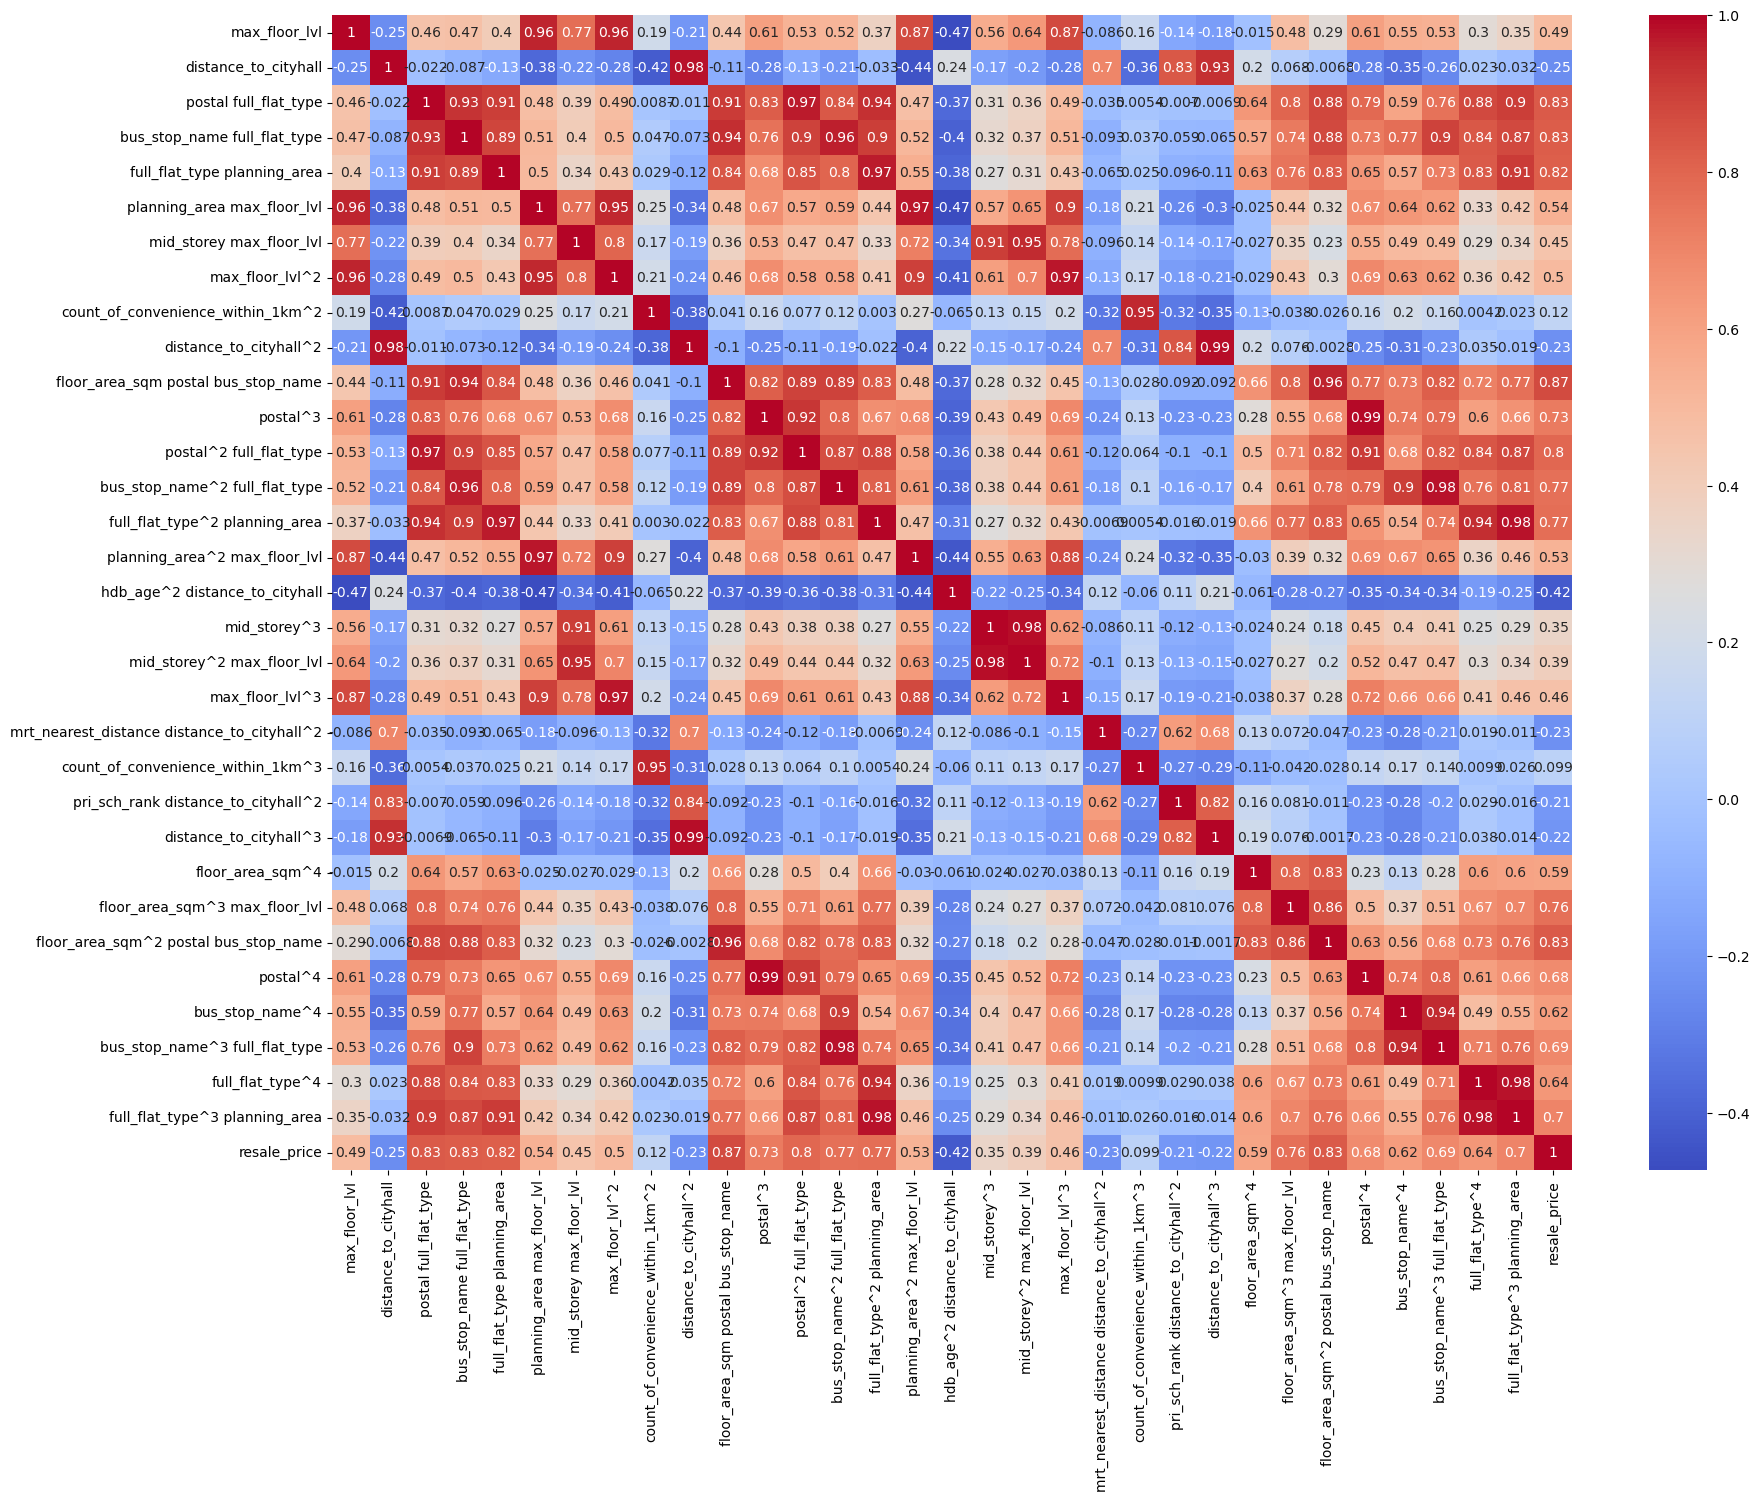

In [153]:
# Correlation heatmap of selected features - part 1

plt.figure(figsize=(20,15))
sns.heatmap(X_poly_with_resale_prices_1.corr(), cmap='coolwarm', annot=True);

# Most of 32 top polynomial features here have strong positive corr with resale_prices (mostly red)

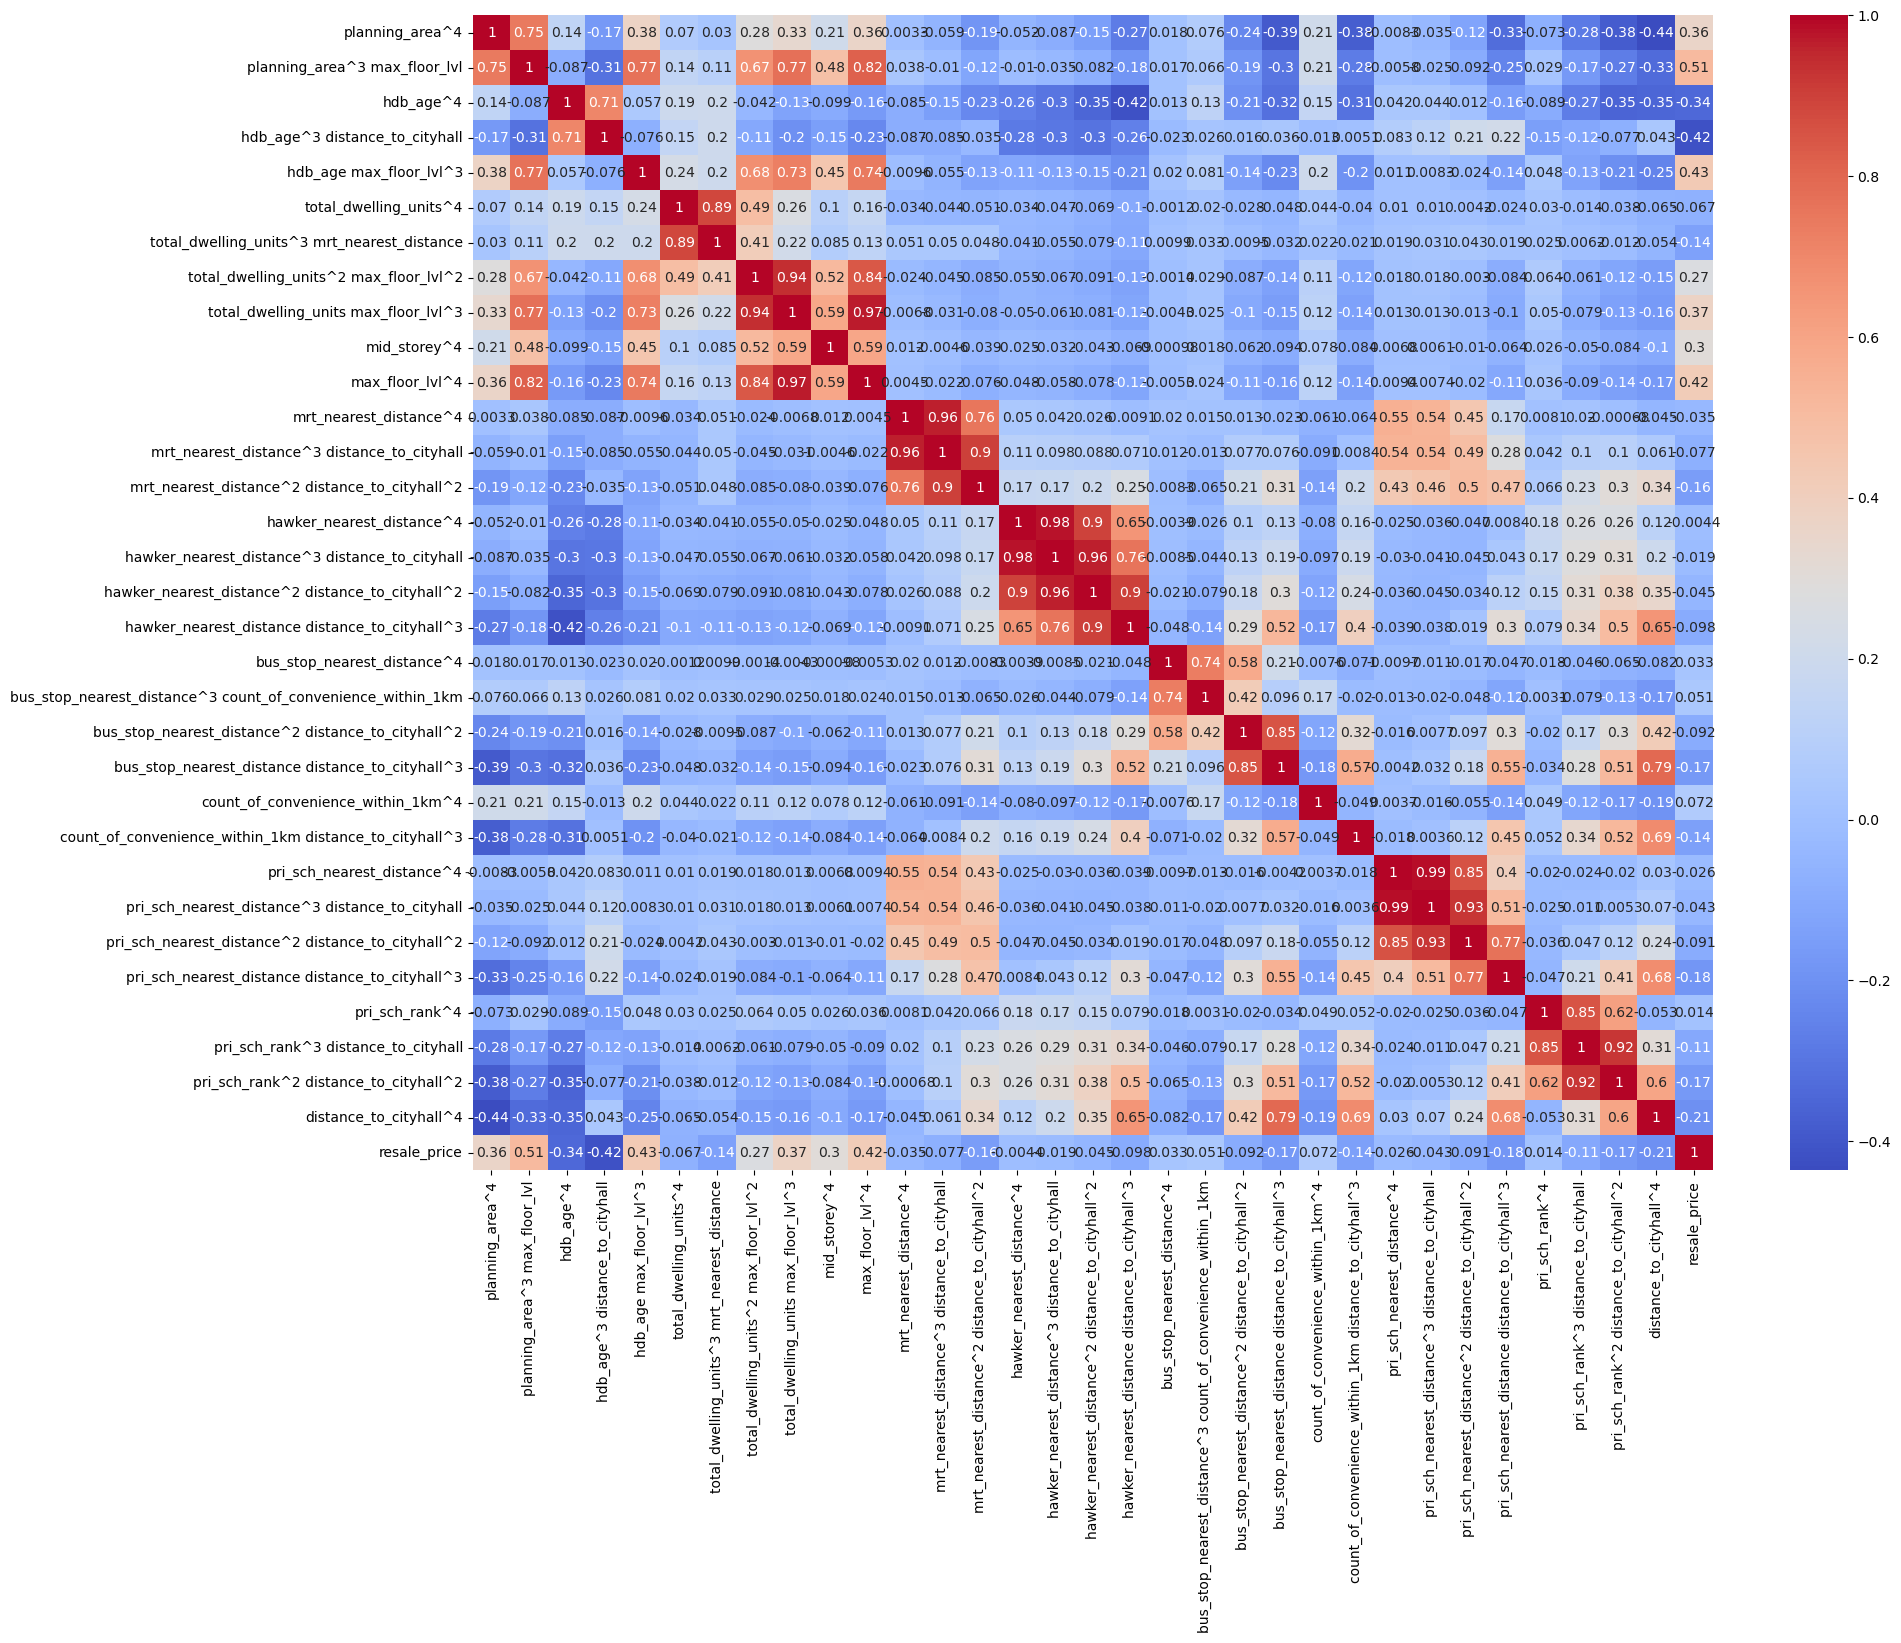

In [154]:
# Correlation heatmap of selected features - part 2

plt.figure(figsize=(20,15))
sns.heatmap(X_poly_with_resale_prices_2.corr(), cmap='coolwarm', annot=True);

# Most of 32 top polynomial features here have strong negative corr with resale_prices (mostly blue)

In [176]:
# Fitted with the top 64 polynomial features 

fitted_model_3 = ordinary_linreg(X_poly_df, y_train, X_poly_df_test, top_features_list, 
                                 with_poly=False, 
                                 poly_degree=4, 
                                 standardscale=False)


# Not great, doesn't work

RMSE: 55435.24944548787
R2_train: 0.8514398055331984
R2_val: 0.849716639836686
Baseline cross-val_score: 55458.88721266047
Number of features: 64


In [169]:
# Selecting the highest of positive and negative correlated features 

best_of_best_features = ['postal full_flat_type',
                         'bus_stop_name full_flat_type',
                         'full_flat_type planning_area',
                         'floor_area_sqm postal bus_stop_name',
                         'planning_area^3 max_floor_lvl',
                         'hdb_age^3 distance_to_cityhall',
                         'hdb_age^4',
                         'total_dwelling_units^3 mrt_nearest_distance',
                         'mrt_nearest_distance^2 distance_to_cityhall^2',
                         'count_of_convenience_within_1km distance_to_cityhall^3',
                         'pri_sch_nearest_distance distance_to_cityhall^3',
                         'pri_sch_rank^2 distance_to_cityhall^2',
                         'distance_to_cityhall^4',
                         'max_floor_lvl^4',
                         'mid_storey^3',
                        ]

In [167]:
# Fitted with the "best of best" polynomial features 

fitted_model_4 = ordinary_linreg(X_poly_df, y_train, X_poly_df_test, best_of_best_features, 
                                 with_poly=False, 
                                 poly_degree=4, 
                                 standardscale=False)


# Not great too, doesn't work

RMSE: 61451.23837378328
R2_train: 0.8212949289124423
R2_val: 0.815328378210079
Baseline cross-val_score: 60696.86860070175
Number of features: 15


# Part 4: Kaggle Submission

In [218]:
original_test_df = pd.read_csv('./datasets/test.csv')

y_preds = fitted_model_2.predict(transformed_X_test)     # Change fitted_model here will do

# Create csv for Kaggle Submission
submission_csv = pd.DataFrame(columns=['Id', 'Predicted'])
submission_csv['Id'] = original_test_df['id']
submission_csv['Predicted'] = y_preds

submission_csv.to_csv('./datasets/kaggle_submission.csv', index=False)

C:\Users\leagu\AppData\Local\Temp\ipykernel_3536\2470486591.py:1: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  original_test_df = pd.read_csv('./datasets/test.csv')
